In [1]:
import pandas as pd
import numpy as np
import os

from config import *

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
#Получаем список под дерикторий, состовляем два списка: полное наименование пути и метки класса
path_list = os.listdir(DATA_PATH)

list_filenames = []
categories = []
for category in path_list:
    img_dir = os.path.join(DATA_PATH, category)
    img_list = os.listdir(img_dir)
    for img_id in img_list:
        list_filenames.append(os.path.join(img_dir, img_id))
        categories.append(category)        

In [3]:
df = pd.DataFrame({
    'filename': list_filenames,
    'category': categories
})
df.head(3)

,filename,category
0,G:/data/internship_data/female\000001.jpg,female
1,G:/data/internship_data/female\000004.jpg,female
2,G:/data/internship_data/female\000009.jpg,female


In [4]:
#Модель состоит из 3 сверточных слоев и одного полносвязного
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=IMG_SHAPE))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # т.к. классов сего 2

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [5]:
earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [6]:
train_df, valid_df = train_test_split(df, test_size=0.30, random_state=42)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

In [7]:
total_train = train_df.shape[0]
total_valid = valid_df.shape[0]

In [8]:
#Предобробатываем изображени, создовая несколько дополнительных его вариантов
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='category',
    target_size=IMG_SHAPE[:2],
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 70001 validated image filenames belonging to 2 classes.


In [9]:
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_dataframe(
    valid_df, 
    x_col='filename',
    y_col='category',
    target_size=IMG_SHAPE[:2],
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 30001 validated image filenames belonging to 2 classes.


In [10]:
history = model.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=valid_generator,
    validation_steps=total_valid//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/50
1093/1093 [==============================] - 550s 503ms/step - loss: 0.4166 - accuracy: 0.8287 - val_loss: 0.2307 - val_accuracy: 0.9069 - lr: 0.0010
Epoch 2/50
1093/1093 [==============================] - 354s 324ms/step - loss: 0.2238 - accuracy: 0.9088 - val_loss: 0.2764 - val_accuracy: 0.8869 - lr: 0.0010
Epoch 3/50
1093/1093 [==============================] - ETA: 0s - loss: 0.1877 - accuracy: 0.9249
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1093/1093 [==============================] - 354s 324ms/step - loss: 0.1877 - accuracy: 0.9249 - val_loss: 1.3907 - val_accuracy: 0.7371 - lr: 0.0010
Epoch 4/50
1093/1093 [==============================] - 354s 323ms/step - loss: 0.1497 - accuracy: 0.9404 - val_loss: 0.1336 - val_accuracy: 0.9506 - lr: 5.0000e-04
Epoch 5/50
1093/1093 [==============================] - 354s 324ms/step - loss: 0.1430 - accuracy: 0.9446 - val_loss: 0.1023 - val_accuracy: 0.9609 - lr: 5.0000e-04
Epoch 6/50
1093/1093

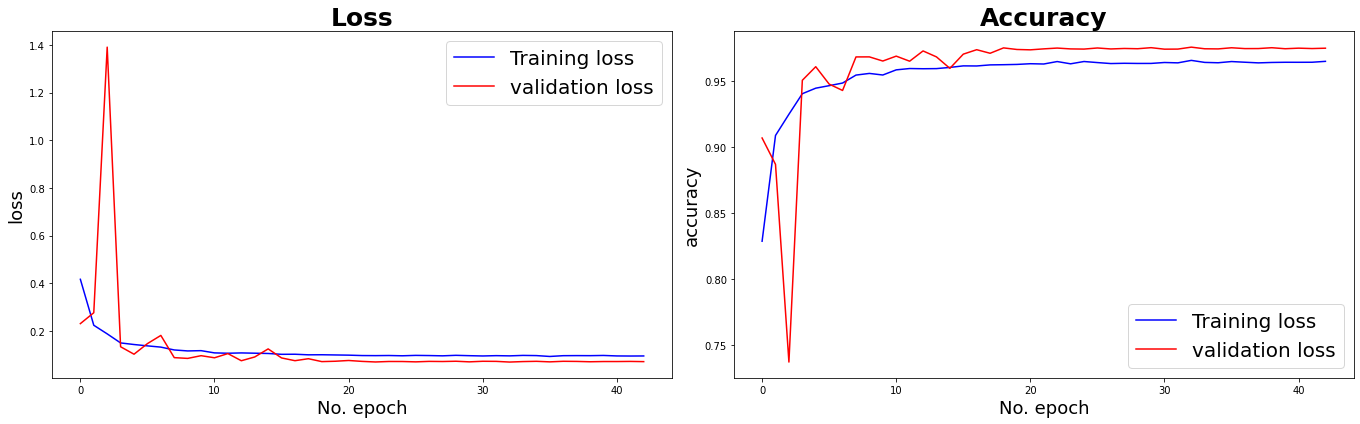

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 6))

ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_title('Loss',fontweight="bold", size=25)
lgnd = ax1.legend(["Training loss",
                  "validation loss"],
                  fontsize=20,
                  loc='upper right')

ax1.set_xlabel('No. epoch', fontsize=18)
ax1.set_ylabel('loss', fontsize=18)

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy", markersize=12)
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_title('Accuracy',fontweight="bold", size=25)
ax2.set_xlabel('No. epoch', fontsize=18)
ax2.set_ylabel('accuracy', fontsize=18)

lgnd = ax2.legend(["Training loss",
                  "validation loss"],
                  fontsize=20,
                  loc='lower right')


plt.tight_layout()
plt.show()

In [12]:
model.save("model.h5")

In [13]:
test_filenames = os.listdir("./test/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]
test_df.head(3)

,filename
0,126122.jpg
1,126287.jpg
2,126384.jpg


In [14]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    './test/',
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMG_SHAPE[:2],
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 9 validated image filenames.


In [15]:
test_generator

In [16]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/BATCH_SIZE))
test_df['category'] = np.argmax(predict, axis=-1)

In [17]:
test_df['category'] = test_df['category'].replace({ 1:'male', 0:'female' })

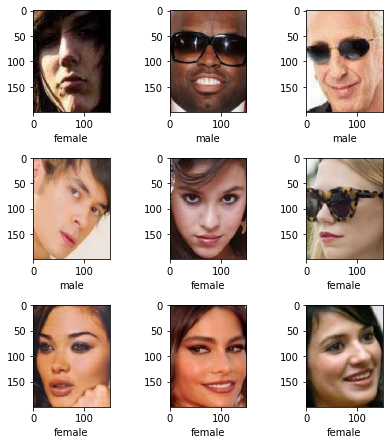

In [18]:
sample_test = test_df.head(9)
sample_test.head()
plt.figure(figsize=(6, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img('./test/'+filename, target_size=IMG_SHAPE[:2])
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(category)
plt.tight_layout()
plt.show()